# DubverseAI
This notebook contains the Neural Machine Translation Transformer Model which we have built to Translate English to Hindi Sentences.



In [1]:
! pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import wandb

wandb.login()

wandb: Currently logged in as: srddev. Use `wandb login --relogin` to force relogin


True

In [3]:
wandb.init(project="DubverseAI")

#### Imports

In [4]:
import pathlib
import random
import string
import re
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.layers import Bidirectional,GRU,LSTM,Embedding
from tensorflow.keras.layers import Dense,MultiHeadAttention,LayerNormalization,Embedding,Dropout,Layer
from tensorflow.keras import Sequential,Input
from tensorflow.keras.callbacks import ModelCheckpoint

from nltk.translate.bleu_score import sentence_bleu

#### Data prepration

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import pandas as pd
import pathlib

train_data = pd.read_csv('/content/drive/MyDrive/NeuroHack/data/NeuroHack_train.csv')
col1 = train_data["English"]
col2 = train_data['Hindi']
with open('train.txt', 'w') as f:
    for i in range(len(col1)):
        f.write(col1[i]+col2[i])

val_data = pd.read_csv('/content/drive/MyDrive/NeuroHack/data/NeuroHack_valid.csv')
col1 = val_data["English"]
col2 = val_data['Hindi']
with open('val.txt', 'w') as f:
    for i in range(len(col1)):
        f.write(col1[i]+col2[i])

In [7]:
English = []
Hindi = []
def lines_tag(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
        for i, line in enumerate(lines):
            if (i+1) % 2 == 0:
                Hindi.append("[start] " + line + " [end]")
            else:
              English.append(line)

In [8]:
def lines_tag(file_path):
  Hindi = []
  English = []
  with open(file_path, 'r') as file:
        lines = file.readlines()
        for i, line in enumerate(lines):
            if (i+1) % 2 == 0:
                Hindi.append("[start] " + line + " [end]")
            else:
                English.append(line)
  return English,Hindi

In [9]:
train_English , train_Hindi = lines_tag('/content/train.txt')
train_pairs = []
for i in range(0,len(train_English)):
  train_pairs.append((train_English[i],train_Hindi[i]))

In [10]:
val_English , val_Hindi  = lines_tag('/content/val.txt')
val_pairs = []
for i in range(0,len(val_English)):
  val_pairs.append((val_English[i],val_Hindi[i]))

In [11]:
train_pairs[0]

('Program module is a file that contains instructions which are either in the form of source code or machine language.\n',
 '[start] माड्यूल, एक संचिका होती है, जिसमें या तो स्रोत कोड या मशीन भाषा के रूप में अनुदेश निहित होते हैं।\n [end]')

#### Preprocessing Data

In [12]:
import string
strip_chars = string.punctuation + "¿"
strip_chars = string.punctuation + "\n"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

In [13]:
def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(
        lowercase, f"[{re.escape(strip_chars)}]", "")

In [14]:
vocab_size = 2531
sequence_length = 160

source_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
)
target_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
    standardize=custom_standardization,
)
train_english_texts = [pair[0] for pair in train_pairs]
train_hinglish_texts = [pair[1] for pair in train_pairs]
source_vectorization.adapt(train_english_texts)
target_vectorization.adapt(train_hinglish_texts)

In [15]:
vocab_size = 2531
sequence_length = 160

source_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
)
target_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
    standardize=custom_standardization,
)
train_english_texts = [pair[0] for pair in train_pairs]
train_hindi_texts = [pair[1] for pair in train_pairs]
source_vectorization.adapt(train_english_texts)
target_vectorization.adapt(train_hindi_texts)
batch_size = 32

def format_dataset(eng, hindi):
    eng = source_vectorization(eng)
    hindi = target_vectorization(hindi)
    return ({
        "english": eng,
        "hindi": hindi[:, :-1],
    }, hindi[:, 1:])

def make_dataset(pairs):
    eng_texts, hindi_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    hindi_texts = list(hindi_texts)
    dataset = tf.data.Dataset.from_tensor_slices((eng_texts, hindi_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset, num_parallel_calls=4)
    return dataset.shuffle(2048).prefetch(16).cache()

train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

In [16]:
for inputs, targets in train_ds.take(1):
    print(f"english\n {inputs['english']}")
    print("------------------------------------------------")
    print(f"hindi\n {inputs['hindi']}")

english
 [[   2  301    3 ...    0    0    0]
 [  14    9   69 ...    0    0    0]
 [   6  239 1681 ...    0    0    0]
 ...
 [   2  941    3 ...    0    0    0]
 [1123    2 1175 ...    0    0    0]
 [   2    1   27 ...    0    0    0]]
------------------------------------------------
hindi
 [[   2  821    6 ...    0    0    0]
 [   2    6  459 ...    0    0    0]
 [   2  277    5 ...    0    0    0]
 ...
 [   2 1677    9 ...    0    0    0]
 [   2 1750    1 ...    0    0    0]
 [   2 1730    1 ...    0    0    0]]


#### Building Transformer Model

##### Encoder

In [17]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=padding_mask
        )
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

##### Decoder

In [18]:
class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(latent_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs, value=inputs, key=inputs, attention_mask=causal_mask
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)
        return self.layernorm_3(out_2 + proj_output)

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)

##### POS

In [19]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

In [20]:
class TransformerModel(tf.keras.models.Model):
    def __init__(self, sequence_length, vocab_size, embed_dim=256, dense_dim=2048, num_heads=8):
        super(TransformerModel, self).__init__()
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size

        self.encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="english")
        self.x = PositionalEmbedding(self.sequence_length, self.vocab_size, self.embed_dim)(self.encoder_inputs)
        self.encoder_outputs = TransformerEncoder(self.embed_dim, self.dense_dim, self.num_heads)(self.x)

        self.decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="hindi")
        self.x = PositionalEmbedding(self.sequence_length, self.vocab_size, self.embed_dim)(self.decoder_inputs)
        self.x = TransformerDecoder(self.embed_dim, self.dense_dim, self.num_heads)(self.x, self.encoder_outputs)
        self.x = Dropout(0.25)(self.x)
        self.decoder_outputs = Dense(self.vocab_size, activation="softmax")(self.x)

    def call(self):
        return keras.Model([self.encoder_inputs, self.decoder_inputs], self.decoder_outputs)

In [22]:
transformer_model = TransformerModel(sequence_length=160, vocab_size=2531)
model = transformer_model.call()

In [23]:
model_config = model.get_config()

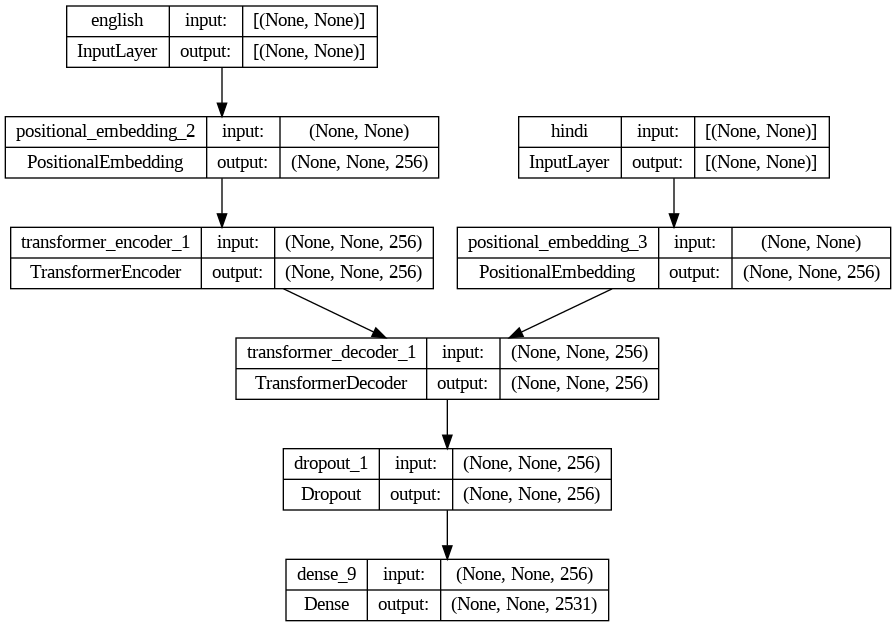

In [24]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='translator.png', show_shapes=True)
from IPython.display import Image
Image("translator.png")

In [25]:
EPOCHS = 70

In [26]:
checkpoint = ModelCheckpoint(filepath='DubverseAI.hdf5',save_weights_only=True,verbose=2,monitor='accuracy')

In [28]:
from wandb.keras import WandbCallback

callbacks = [checkpoint, WandbCallback()]

model.compile(optimizer="Adam",loss="sparse_categorical_crossentropy",metrics=["accuracy"])
history = model.fit(train_ds, epochs=EPOCHS, callbacks=callbacks, validation_data=val_ds)

Epoch 1/70
81/81 [==============================] - ETA: 0s - loss: 5.2105 - accuracy: 0.2372
Epoch 1: saving model to DubverseAI.hdf5


wandb: Adding directory to artifact (/content/wandb/run-20230505_154859-cmc71olz/files/model-best)... Done. 0.4s


81/81 [==============================] - 57s 567ms/step - loss: 5.2105 - accuracy: 0.2372 - val_loss: 4.3736 - val_accuracy: 0.3090
Epoch 2/70
81/81 [==============================] - ETA: 0s - loss: 4.2132 - accuracy: 0.3039
Epoch 2: saving model to DubverseAI.hdf5


wandb: Adding directory to artifact (/content/wandb/run-20230505_154859-cmc71olz/files/model-best)... Done. 0.5s


81/81 [==============================] - 19s 232ms/step - loss: 4.2132 - accuracy: 0.3039 - val_loss: 3.9482 - val_accuracy: 0.3397
Epoch 3/70
81/81 [==============================] - ETA: 0s - loss: 3.4943 - accuracy: 0.3655
Epoch 3: saving model to DubverseAI.hdf5


wandb: Adding directory to artifact (/content/wandb/run-20230505_154859-cmc71olz/files/model-best)... Done. 0.4s


81/81 [==============================] - 20s 250ms/step - loss: 3.4943 - accuracy: 0.3655 - val_loss: 3.6323 - val_accuracy: 0.3599
Epoch 4/70
81/81 [==============================] - ETA: 0s - loss: 2.8286 - accuracy: 0.4501
Epoch 4: saving model to DubverseAI.hdf5


wandb: Adding directory to artifact (/content/wandb/run-20230505_154859-cmc71olz/files/model-best)... Done. 0.4s


81/81 [==============================] - 20s 248ms/step - loss: 2.8286 - accuracy: 0.4501 - val_loss: 3.4076 - val_accuracy: 0.3791
Epoch 5/70
81/81 [==============================] - ETA: 0s - loss: 2.2217 - accuracy: 0.5434
Epoch 5: saving model to DubverseAI.hdf5


wandb: Adding directory to artifact (/content/wandb/run-20230505_154859-cmc71olz/files/model-best)... Done. 0.4s


81/81 [==============================] - 19s 234ms/step - loss: 2.2217 - accuracy: 0.5434 - val_loss: 3.1797 - val_accuracy: 0.4205
Epoch 6/70
81/81 [==============================] - ETA: 0s - loss: 1.6824 - accuracy: 0.6449
Epoch 6: saving model to DubverseAI.hdf5


wandb: Adding directory to artifact (/content/wandb/run-20230505_154859-cmc71olz/files/model-best)... Done. 0.4s


81/81 [==============================] - 20s 253ms/step - loss: 1.6824 - accuracy: 0.6449 - val_loss: 2.9206 - val_accuracy: 0.4873
Epoch 7/70
81/81 [==============================] - ETA: 0s - loss: 1.2161 - accuracy: 0.7385
Epoch 7: saving model to DubverseAI.hdf5


wandb: Adding directory to artifact (/content/wandb/run-20230505_154859-cmc71olz/files/model-best)... Done. 0.4s


81/81 [==============================] - 20s 242ms/step - loss: 1.2161 - accuracy: 0.7385 - val_loss: 2.6205 - val_accuracy: 0.5508
Epoch 8/70
81/81 [==============================] - ETA: 0s - loss: 0.8563 - accuracy: 0.8130
Epoch 8: saving model to DubverseAI.hdf5


wandb: Adding directory to artifact (/content/wandb/run-20230505_154859-cmc71olz/files/model-best)... Done. 0.4s


81/81 [==============================] - 19s 229ms/step - loss: 0.8563 - accuracy: 0.8130 - val_loss: 2.3904 - val_accuracy: 0.6084
Epoch 9/70
81/81 [==============================] - ETA: 0s - loss: 0.5985 - accuracy: 0.8693
Epoch 9: saving model to DubverseAI.hdf5


wandb: Adding directory to artifact (/content/wandb/run-20230505_154859-cmc71olz/files/model-best)... Done. 0.4s


81/81 [==============================] - 21s 255ms/step - loss: 0.5985 - accuracy: 0.8693 - val_loss: 2.2575 - val_accuracy: 0.6674
Epoch 10/70
81/81 [==============================] - ETA: 0s - loss: 0.4374 - accuracy: 0.9046
Epoch 10: saving model to DubverseAI.hdf5


wandb: Adding directory to artifact (/content/wandb/run-20230505_154859-cmc71olz/files/model-best)... Done. 0.5s


81/81 [==============================] - 20s 251ms/step - loss: 0.4374 - accuracy: 0.9046 - val_loss: 2.2201 - val_accuracy: 0.6895
Epoch 11/70
81/81 [==============================] - ETA: 0s - loss: 0.3250 - accuracy: 0.9283
Epoch 11: saving model to DubverseAI.hdf5
81/81 [==============================] - 12s 147ms/step - loss: 0.3250 - accuracy: 0.9283 - val_loss: 2.2449 - val_accuracy: 0.7002
Epoch 12/70
81/81 [==============================] - ETA: 0s - loss: 0.2504 - accuracy: 0.9450
Epoch 12: saving model to DubverseAI.hdf5
81/81 [==============================] - 11s 139ms/step - loss: 0.2504 - accuracy: 0.9450 - val_loss: 2.2543 - val_accuracy: 0.7102
Epoch 13/70
81/81 [==============================] - ETA: 0s - loss: 0.1976 - accuracy: 0.9555
Epoch 13: saving model to DubverseAI.hdf5
81/81 [==============================] - 11s 140ms/step - loss: 0.1976 - accuracy: 0.9555 - val_loss: 2.2335 - val_accuracy: 0.7240
Epoch 14/70
81/81 [==============================] - ETA: 0s 

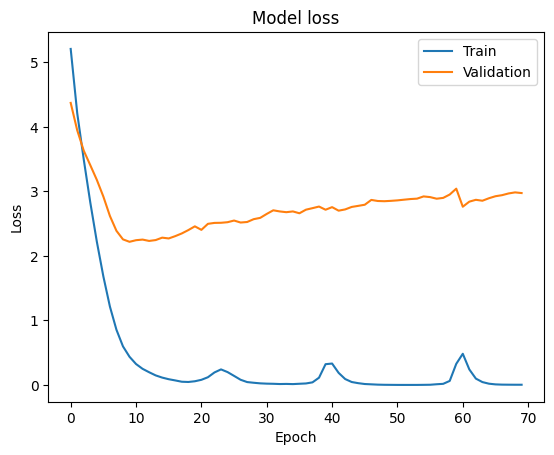

In [29]:
import matplotlib.pyplot as plt

#plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

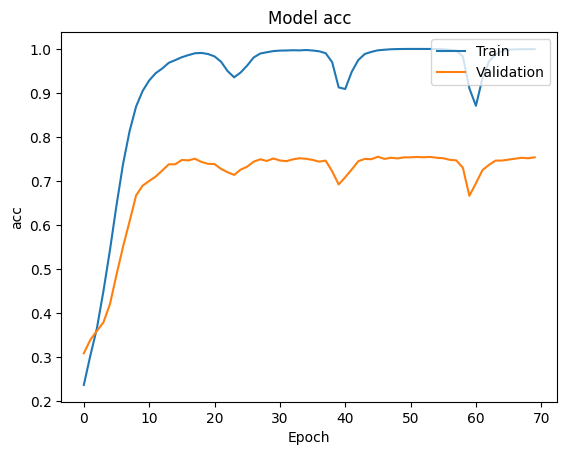

In [30]:
#plot the training and validation loss
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model acc')
plt.ylabel('acc')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

### Saving the model

In [31]:
model.save('model.h5')

In [32]:
loaded_model = keras.models.load_model('model.h5',
                                       custom_objects={'PositionalEmbedding': PositionalEmbedding,'TransformerEncoder':TransformerEncoder,'TransformerDecoder':TransformerDecoder})

In [33]:
# saving model achitecture in json file
model_json = loaded_model.to_json()
with open("translator.json", "w") as json_file:
    json_file.write(model_json)

In [34]:
hindi_vocab = target_vectorization.get_vocabulary()
hindi_index_lookup = dict(zip(range(len(hindi_vocab)), hindi_vocab))
max_decoded_sentence_length = 158

#Inference

In [40]:
def decode_sequence(input_sentence):
  #toekn input
  max_decoded_sentence_length = 160
  tokenized_input_sentence = source_vectorization([input_sentence])
  #token input
  decoded_sentence = "[start]"
  for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = target_vectorization(
            [decoded_sentence])[:, :-1]
        predictions = loaded_model(
            [tokenized_input_sentence, tokenized_target_sentence])
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = hindi_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token
        if sampled_token == "[end]":
            break
        decoded_sentence = decoded_sentence.replace("[start]", "")
        new = decoded_sentence.replace("[end]", "")
  return new

### Different inputs

In [43]:
output = decode_sequence("Action is the foundational key to all success.")
print(output)

 कर्म क्रांतिकारी जो [UNK] [UNK] [UNK] [UNK] के [UNK]


In [45]:
output = decode_sequence("I am learning for you.")
print(output)

 मैं मैं आपके [UNK] [UNK] तुम [UNK] के [UNK]
